In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

### Loading in TESS Sector 14 Data

In [2]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '273589987'
gj1243_tess = search_lightcurvefile(target,cadence='short').download_all()

In [3]:
gj1243_tess[11].time

array([1683.35617589, 1683.3575648 , 1683.35895371, ..., 1710.20359189,
       1710.20498078, 1710.20636967])

In [4]:
tess_collection=gj1243_tess[-2:]
tess_collection

[TessLightCurveFile(TICID: 273589987), TessLightCurveFile(TICID: 273589987)]

In [5]:
print(gj1243_tess[11].PDCSAP_FLUX)

TessLightCurve(TICID: 273589987)


In [6]:
gj1243_tesslc = tess_collection[0].PDCSAP_FLUX

for q in range(1,len(tess_collection)):
    try:
        gj1243_tesslc = gj1243_tesslc.append(tess_collection[q].PDCSAP_FLUX)
    except:
            print(q)

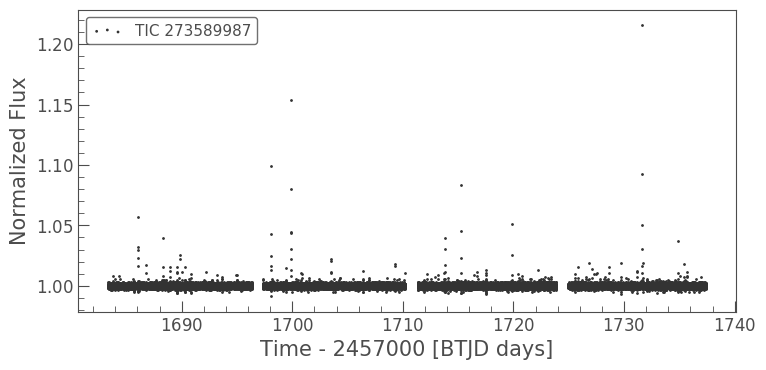

In [7]:
gj1243_tesslc.flatten(window_length=11).scatter()

### Loading in Flare tables

In [8]:
#Sector 14
fbeye14 = pd.read_csv('gj1243_tess_flares.dat.fbeye',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]

In [9]:
#Sector 15
fbeye15 = pd.read_csv('gj1243_tess15.dat.fbeye',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]

In [10]:
#combine the two fbeye files
filenames = ['gj1243_tess_flares.dat.fbeye', 'gj1243_tess15.dat.fbeye']
with open('/Users/lupitatovar/TESS/all_tess_flares.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())
            

In [11]:
all_tess_flares= pd.read_csv('all_tess_flares.txt',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]

In [12]:
#mask the flares we found
t_starts = all_tess_flares.loc[:,'t_start'].values
t_stops = all_tess_flares.loc[:,'t_stop'].values
flux_peak = all_tess_flares.loc[:,'Flux_peak'].values

#mask array for TESS lightcurve
f_mask = np.zeros_like(gj1243_tesslc.time, dtype=bool)

In [13]:
for i in range(len(t_starts)):
    temp = (gj1243_tesslc.time >= t_starts[i]) & (gj1243_tesslc.time <= t_stops[i])
    f_mask = f_mask + temp 
print(f_mask)


no_flare = np.where((f_mask == False))[0]
flares = np.where((f_mask == True))[0]

[False False False ... False False False]


In [14]:
gj1243_tesslc.flux[18900:]

array([10995.22 , 11016.394, 10953.372, ..., 10954.027, 10940.631,
       10977.876], dtype=float32)

In [15]:
flat_lc = gj1243_tesslc.flatten()
flares_x=flat_lc.time[f_mask]
#flares_x[:9200]
flares_y = flat_lc.flux[f_mask]/np.nanmedian(flat_lc.flux)
print(len(flares_y[:9350]))
#print(len(gj1243_tess[11].flux[f_mask]/np.nanmedian(gj1243_tesslc.flux[f_mask])))

1725


In [16]:
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

NameError: name 'matplotlib' is not defined

### Plotting the TESS lightcurve with identified flares

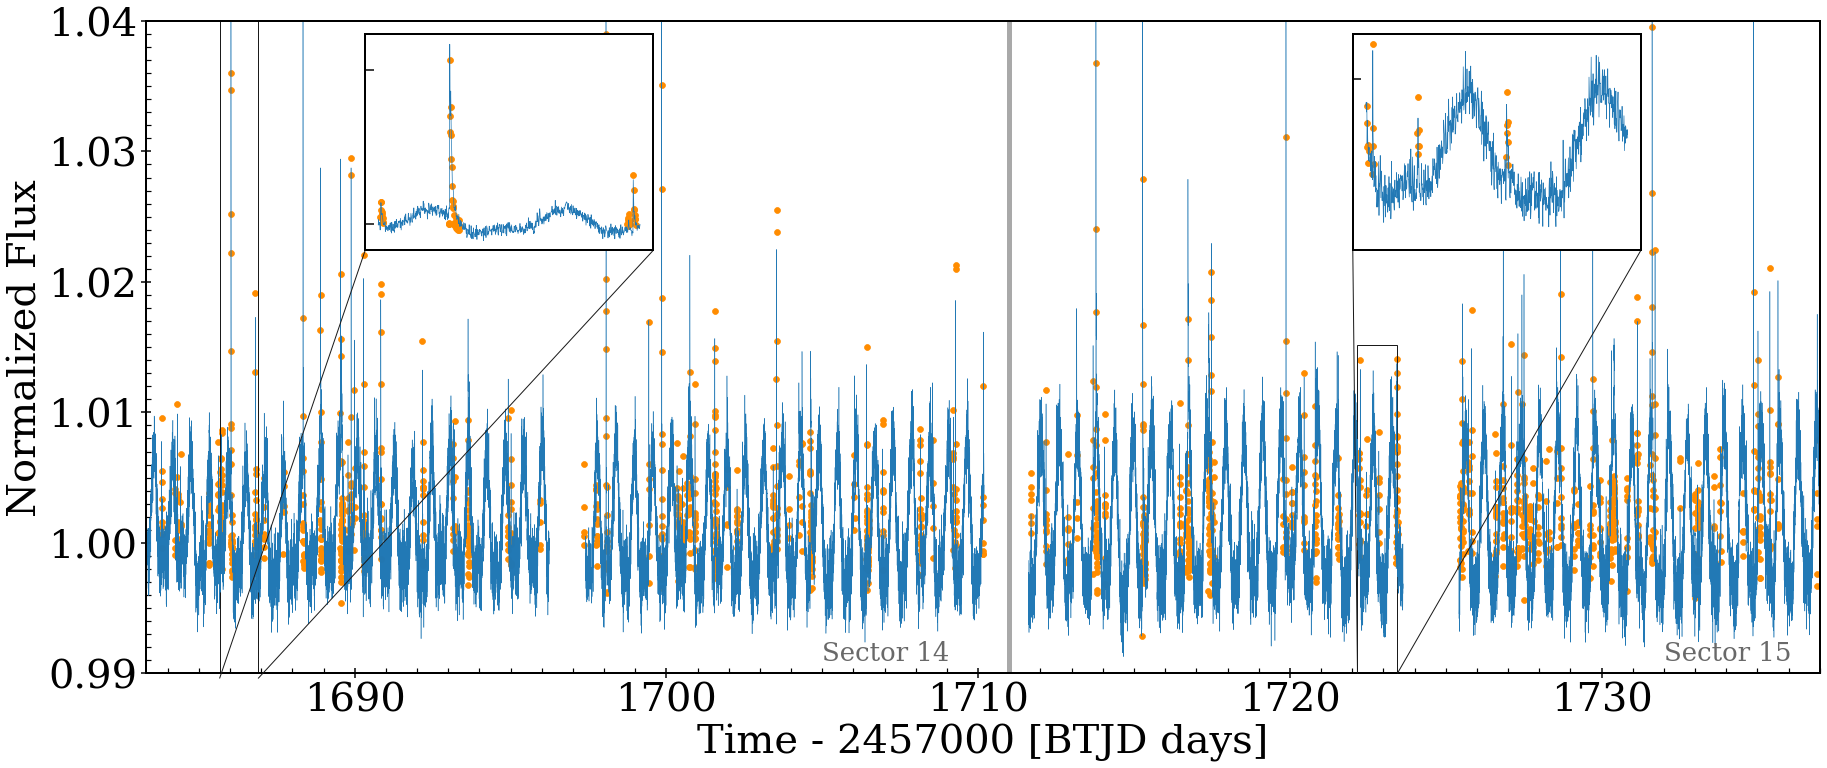

In [133]:
fig,ax = plt.subplots(figsize=(30,12))
#font = {'size'   : 40}
#plt.rc('font', **font)
import matplotlib
matplotlib.rcParams.update({'font.size':40})
matplotlib.rcParams.update({'font.family':'serif'})

#plotting the TESS light curve (exculdes missing data)
plt.plot(gj1243_tesslc.time[:9200],gj1243_tesslc.flux[:9200]/np.nanmedian(gj1243_tesslc.flux[:18520]),linewidth=0.5,alpha=0.99,color='C0')
plt.plot(gj1243_tesslc.time[9350:18510],gj1243_tesslc.flux[9350:18510]/np.nanmedian(gj1243_tesslc.flux[:18520]),linewidth=0.5,color='C0',alpha=0.99)
plt.plot(gj1243_tesslc.time[18700:27300],gj1243_tesslc.flux[18700:27300]/np.nanmedian(gj1243_tesslc.flux[18900:]),linewidth=0.5,color='C0',alpha=0.99)
plt.plot(gj1243_tesslc.time[27800:],gj1243_tesslc.flux[27800:]/np.nanmedian(gj1243_tesslc.flux[18900:]),linewidth=0.5,color='C0',alpha=0.99)

plt.scatter(flares_x,flares_y,linewidth=0.7,color='darkorange',s=35)

#line to sperate sectors
plt.axvline(x=1711, color='darkgrey',linewidth=5)

#Text
plt.text(1705, .991, 'Sector 14', fontsize=26, color ='dimgrey')
plt.text(1732, .991, 'Sector 15', fontsize=26, color ='dimgrey')

#axes
ax.set_ylim([0.99,1.04])
ax.set_xlim([1683.3,1737])
plt.rcParams['axes.linewidth']=2

plt.tick_params(axis='both',direction="in")
from matplotlib.ticker import (AutoMinorLocator,MultipleLocator)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='minor', direction='in',width=1.2,length=5)
ax.yaxis.set_minor_locator(MultipleLocator(.002))

plt.tick_params(axis='both',direction="in",width=1.5,length=10)


plt.xlabel('Time - 2457000 [BTJD days]')
plt.ylabel('Normalized Flux')
plt.tick_params(axis='both',direction="inout")

#subplots for 1 day zoom in

#sector 14
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

inset_axes1 = inset_axes(ax, width=4.0, height=3,bbox_to_anchor=(-.585,0.11,.9,.9),
                 bbox_transform=ax.transAxes)
plt.plot(gj1243_tesslc.time[1690:2500],gj1243_tesslc.flux[1690:2500]/np.nanmedian(gj1243_tesslc.flux[:18520]),linewidth=0.7,alpha=5,color='C0')
plt.scatter(flares_x[70:130],flares_y[70:130],linewidth=0.8,color='darkorange',s=35)
plt.xticks([])
plt.yticks([1,1.06])
plt.tick_params(axis='both',direction="in",width=1.5,length=9)

plt.setp(inset_axes1.get_xticklabels(),visible=False)
plt.setp(inset_axes1.get_yticklabels(), visible=False)

mark_inset(ax, inset_axes1, loc1=3, loc2=4, fc="none", ec="0.1")

#sector 15
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
inset_axes = inset_axes(ax, width=4.0, height=3,bbox_to_anchor=(0.005,0.11,.9,.9),
                 bbox_transform=ax.transAxes)
plt.plot(gj1243_tesslc.time[26290:27130],gj1243_tesslc.flux[26290:27130]/np.nanmedian(gj1243_tesslc.flux[18900:]),linewidth=0.7,alpha=5,color='C0')
plt.scatter(flares_x[1190:1215],flares_y[1190:1215],linewidth=0.8,color='darkorange',s=35)
plt.xticks([])
plt.yticks([0.99,1.01])
plt.tick_params(axis='both',direction="in",width=1.5,length=8)
ax.yaxis.set_minor_locator(MultipleLocator(.001))
plt.setp(inset_axes.get_xticklabels(),visible=False)
plt.setp(inset_axes.get_yticklabels(), visible=False)
mark_inset(ax, inset_axes, loc1=3, loc2=4, fc="none", ec="0.1")


#plt.savefig('gj1243_tess_full_lc.pdf',dpi=300, bbox_inches='tight', pad_inches=0.5)

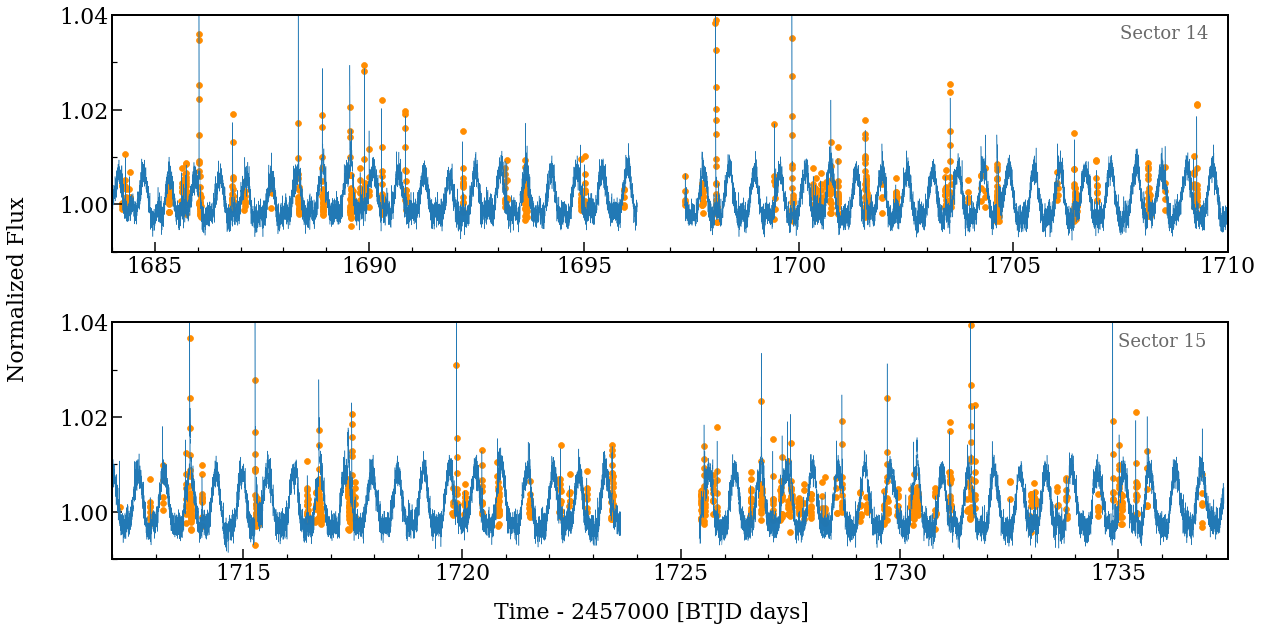

In [144]:
fig,axs = plt.subplots(2,sharey=True,sharex=False,figsize=(20,10))
#font = {'size'   : 40}
#plt.rc('font', **font)
import matplotlib
matplotlib.rcParams.update({'font.size':22})
matplotlib.rcParams.update({'font.family':'serif'})

fig.subplots_adjust(hspace=0.3, wspace=0.4)



#plotting the TESS light curve (exculdes missing data)
axs[0].plot(gj1243_tesslc.time[:9200],gj1243_tesslc.flux[:9200]/np.nanmedian(gj1243_tesslc.flux[:18520]),linewidth=0.5,alpha=0.99,color='C0')
axs[0].plot(gj1243_tesslc.time[9310:18510],gj1243_tesslc.flux[9310:18510]/np.nanmedian(gj1243_tesslc.flux[:18520]),linewidth=0.5,color='C0',alpha=0.99)


axs[1].plot(gj1243_tesslc.time[19000:27300],gj1243_tesslc.flux[19000:27300]/np.nanmedian(gj1243_tesslc.flux[19000:]),linewidth=0.5,color='C0',alpha=0.99)
axs[1].plot(gj1243_tesslc.time[27800:],gj1243_tesslc.flux[27800:]/np.nanmedian(gj1243_tesslc.flux[18900:]),linewidth=0.5,color='C0',alpha=0.99)

axs[0].scatter(flares_x[:830],flares_y[:830],linewidth=0.7,color='darkorange',s=35)
axs[1].scatter(flares_x[850:],flares_y[850:],linewidth=0.7,color='darkorange',s=35)

#line to sperate sectors
#plt.axvline(x=1711, color='darkgrey',linewidth=5)

#Text
axs[0].text(1707.5, 1.035, 'Sector 14', fontsize=18, color ='dimgrey')
axs[1].text(1735, 1.035, 'Sector 15', fontsize=18, color ='dimgrey')

#axes
axs[0].set_ylim([0.99,1.04])
axs[0].set_xlim([1684,1710])
axs[1].set_xlim([1712,1737.5])

plt.rcParams['axes.linewidth']=2

plt.tick_params(axis='both',direction="in")
from matplotlib.ticker import (AutoMinorLocator,MultipleLocator)
axs[0].xaxis.set_minor_locator(MultipleLocator(1))
axs[0].tick_params(which='minor', direction='in',width=1.2,length=5)
axs[0].yaxis.set_minor_locator(MultipleLocator(.01))
axs[0].tick_params(axis='both',direction="in",width=1.5,length=10)
axs[1].xaxis.set_minor_locator(MultipleLocator(1))
axs[1].tick_params(which='minor', direction='in',width=1.2,length=5)
axs[1].yaxis.set_minor_locator(MultipleLocator(.01))
axs[1].tick_params(axis='both',direction="in",width=1.5,length=10)
#axs[1].set_xlabel('Time - 2457000 [BTJD days]')
fig.text(0.06, 0.5, 'Normalized Flux', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.05, 'Time - 2457000 [BTJD days]', ha='center', va='center')

#subplots for 1 day zoom in

#sector 14
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

inset_axes1 = inset_axes(ax, width=4.0, height=3,bbox_to_anchor=(-.585,0.11,.9,.9),
                 bbox_transform=ax.transAxes)
#plt.plot(gj1243_tesslc.time[1690:2500],gj1243_tesslc.flux[1690:2500]/np.nanmedian(gj1243_tesslc.flux[:18520]),linewidth=0.7,alpha=5,color='C0')
#plt.scatter(flares_x[70:130],flares_y[70:130],linewidth=0.8,color='darkorange',s=35)
#plt.xticks([])
#plt.yticks([1,1.06])
#plt.tick_params(axis='both',direction="in",width=1.5,length=9)

plt.setp(inset_axes1.get_xticklabels(),visible=False)
plt.setp(inset_axes1.get_yticklabels(), visible=False)

mark_inset(ax, inset_axes1, loc1=3, loc2=4, fc="none", ec="0.1")

#sector 15
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
inset_axes = inset_axes(ax, width=4.0, height=3,bbox_to_anchor=(0.005,0.11,.9,.9),
                 bbox_transform=ax.transAxes)
#plt.plot(gj1243_tesslc.time[26290:27130],gj1243_tesslc.flux[26290:27130]/np.nanmedian(gj1243_tesslc.flux[18900:]),linewidth=0.7,alpha=5,color='C0')
#plt.scatter(flares_x[1190:1215],flares_y[1190:1215],linewidth=0.8,color='darkorange',s=35)
#plt.xticks([])
#plt.yticks([0.99,1.01])
#plt.tick_params(axis='both',direction="in",width=1.5,length=8)
#ax.yaxis.set_minor_locator(MultipleLocator(.001))
plt.setp(inset_axes.get_xticklabels(),visible=False)
plt.setp(inset_axes.get_yticklabels(), visible=False)
mark_inset(ax, inset_axes, loc1=3, loc2=4, fc="none", ec="0.1")


#plt.savefig('gj1243_tess_lc.pdf',dpi=300, bbox_inches='tight', pad_inches=0.5)

In [67]:
flares_x[:830]

array([1683.80340419, 1683.8047931 , 1683.806182  , 1683.80757091,
       1683.82840452, 1683.82979343, 1683.83118233, 1683.83257124,
       1683.83396015, 1684.23257644, 1684.23396535, 1684.23535426,
       1684.23674316, 1684.23813207, 1684.31313303, 1684.31452194,
       1684.31591085, 1684.31729975, 1684.31868866, 1684.32007757,
       1684.32146647, 1684.32285538, 1684.32424429, 1684.32563319,
       1684.40896759, 1684.4103565 , 1684.41174541, 1684.41313431,
       1684.41452322, 1684.41591213, 1684.41730103, 1685.32147907,
       1685.32286798, 1685.32425689, 1685.32564579, 1685.3270347 ,
       1685.3284236 , 1685.32981251, 1685.33120142, 1685.33259032,
       1685.33397923, 1685.33536813, 1685.33675704, 1685.33814595,
       1685.33953485, 1685.6228717 , 1685.6242606 , 1685.62564951,
       1685.62703842, 1685.62842732, 1685.62981623, 1685.63120513,
       1685.63259404, 1685.63398295, 1685.63537185, 1685.67287231,
       1685.67426122, 1685.67565013, 1685.67703903, 1685.67842

(1685.71, 1686.85)

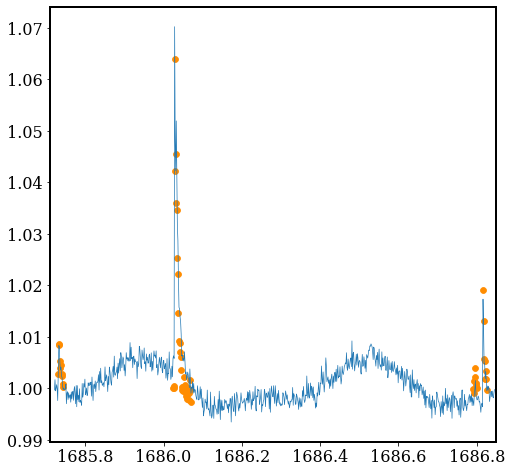

In [27]:
#one day of flares for sector 14
fig,ax = plt.subplots(figsize=(8,8))
font = {'size'   : 16}
plt.rc('font', **font)
plt.plot(gj1243_tesslc.time[1690:2500],gj1243_tesslc.flux[1690:2500]/np.nanmedian(gj1243_tesslc.flux[:18520]),linewidth=0.7,alpha=5,color='C0')
plt.scatter(flares_x[70:130],flares_y[70:130],linewidth=0.8,color='darkorange',s=35)
#ax.set_ylim([0.995,1.015])
ax.set_xlim([1685.71,1686.85])

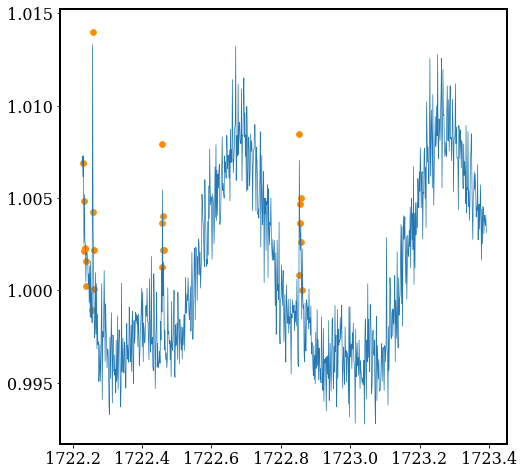

In [26]:
#one day of flares for sector 15
fig,ax = plt.subplots(figsize=(8,8))
font = {'size'   : 16}
plt.rc('font', **font)
plt.plot(gj1243_tesslc.time[26290:27130],gj1243_tesslc.flux[26290:27130]/np.nanmedian(gj1243_tesslc.flux[18900:]),linewidth=0.7,alpha=5,color='C0')
plt.scatter(flares_x[1190:1215],flares_y[1190:1215],linewidth=0.8,color='darkorange',s=35)
#ax.set_ylim([0.995,1.008])
#ax.set_xlim([1727.6,1728.6])

### TESS FFD

In [145]:
Lo=30.352907
tess_sort = np.argsort(all_tess_flares['Equiv_Dur'].values)[::-1]
ED = all_tess_flares['Equiv_Dur'].values[tess_sort]
time = (np.nanmedian(np.diff(flat_lc.time))) * (len(flat_lc.time))
nu = (np.arange(1, len(ED)+1)) / time



#mask the flares we found
t_starts = all_tess_flares.loc[:,'t_start'].values[tess_sort]
t_stops = all_tess_flares.loc[:,'t_stop'].values[tess_sort]

tess_x = np.log10(ED) + (Lo)
#is is log(Lo)???
tess_y = np.log10(nu)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


Text(0.5, 1.0, 'GJ 1243 - TESS Sector 14')

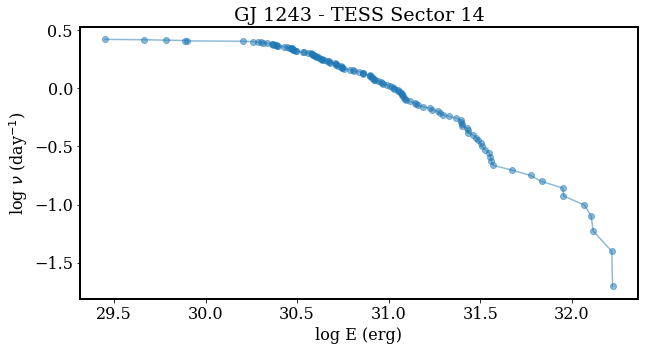

In [146]:
fig = plt.figure(figsize=(10,5))
font = {'size'   : 16}
plt.rc('font', **font)

plt.plot(tess_x,tess_y,'-o', color='C0', alpha=0.5)
plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.title('GJ 1243 - TESS Sector 14')

### Loading in Kepler data & flares from Davenport et al (2014)

In [147]:
# Kepler Flares
kep_Lo = 30.037849     #Jim calculated this value long time ago

kep_lc = pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/1732d4130daf663532596749d566d8f78be8f7b2/data/gj1243_master_slc.dat', delim_whitespace=True, skiprows=1, 
                       names=('time', 'flux', 'error', 'detrended_flux'))
kep_dur = len(kep_lc) * 58.0 / 60./60./24.

kep_flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])
kep_sort = np.argsort(kep_flare_table['ED'].values)[::-1]
kep_ED = kep_flare_table['ED'].values[kep_sort]
kep_starts = kep_flare_table['t_start'].values[kep_sort]
kep_stops = kep_flare_table['t_stop'].values[kep_sort]
kep_time=np.nanmedian(np.diff(kep_lc['time'])) * (len(kep_lc['time']))

In [148]:
kep_x = np.log10(kep_ED) + kep_Lo
kep_y = np.log10(np.arange(1, len(kep_x)+1) / kep_time)

kep_nu = (np.arange(1, len(kep_ED)+1)) / kep_time

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [149]:
dL = 30.665290 - 30.037849
dL

no_nan_mask = np.isfinite(kep_x)

### Fitting the TESS Data

[-0.94881011 29.42930286] [0.02169461 0.67623133]


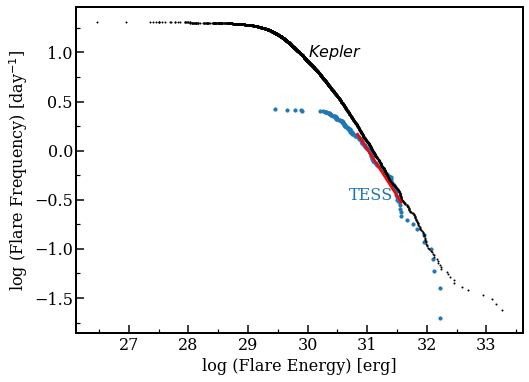

In [150]:
fig,ax = plt.subplots(figsize=(8,6))
font = {'size'   : 18}
plt.rc('font', **font)

plt.scatter(tess_x,tess_y, color='C0',s=10) #, label='TESS'
plt.scatter(kep_x[no_nan_mask],kep_y[no_nan_mask], color='k',s=1)
plt.xlabel('log (Flare Energy) [erg]')
plt.ylabel(r'log (Flare Frequency) [day$^{-1}$]')


# Add labels to the plot
style = dict(size=16)
ax.text(30.7, -0.5, "TESS", **style,color='C0')
ax.text(30, 0.95, "$\it{Kepler}$", **style)

#axes
plt.rcParams['axes.linewidth']=1.5

plt.tick_params(axis='both',direction="in")
from matplotlib.ticker import (AutoMinorLocator,MultipleLocator)
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(which='minor', direction='in',width=1.2,length=4)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
plt.tick_params(axis='both',direction="in",width=1.5,length=8)


from scipy import polyfit

tess_polyfit,cov= np.polyfit(tess_x[10:70],tess_y[10:70],1,full=False, cov=True)

plt.plot(tess_x[10:70],np.polyval(tess_polyfit,tess_x[10:70]),color='red',linewidth=2.5)
print(tess_polyfit,np.sqrt(np.diag(cov))) #uncertainities on m and b


### Fitting the Kepler Data

In [151]:
no_nan_mask = np.isfinite(kep_x)

Kepler [-0.86276608 26.83724469] [0.00138837 0.04231651]
TESS [-0.94881011 29.42930286] [0.02169461 0.67623133]


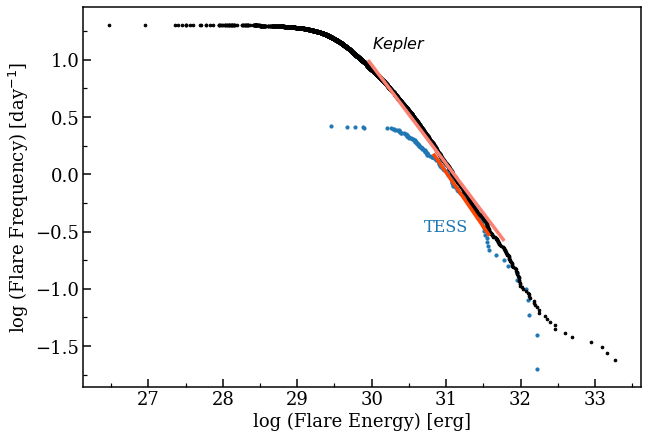

In [152]:
fig,ax = plt.subplots(figsize=(10,7))
font = {'size'   : 20}
plt.rc('font', **font)

plt.scatter(tess_x,tess_y, color='C0',s=10) #, label='TESS'
plt.scatter(kep_x,kep_y, color='k',s=7)
plt.xlabel('log (Flare Energy) [erg]')
plt.ylabel(r'log (Flare Frequency) [day$^{-1}$]')
#plt.title('GJ 1243')
#plt.legend() 

# Add labels to the plot
style = dict(size=16)
ax.text(30.7, -0.5, "TESS", **style,color='C0')
ax.text(30, 1.1, "$\it{Kepler}$", **style)

#axes
plt.rcParams['axes.linewidth']=1.5

plt.tick_params(axis='both',direction="in")
from matplotlib.ticker import (AutoMinorLocator,MultipleLocator)
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(which='minor', direction='in',width=1.2,length=4)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
plt.tick_params(axis='both',direction="in",width=1.5,length=8)

#fitting a line

from scipy import polyfit
kep_polyfit, cov = np.polyfit(kep_x[no_nan_mask][60:2500], kep_y[no_nan_mask][60:2500],1,full=False, cov=True)

plt.plot(kep_x[no_nan_mask][60:2500],np.polyval(kep_polyfit, kep_x[no_nan_mask][60:2500]),color='salmon',linewidth=3.5)
kep_polyfit,np.sqrt(np.diag(cov)) #uncertainities on m and b

print('Kepler',kep_polyfit,np.sqrt(np.diag(cov)))


#Combining both fits onto one plot
tess_polyfit,cov= np.polyfit(tess_x[10:70],tess_y[10:70],1,full=False, cov=True)

plt.plot(tess_x[10:70],np.polyval(tess_polyfit,tess_x[10:70]),color='orangered',linewidth=3.5)
print('TESS',tess_polyfit,np.sqrt(np.diag(cov))) #uncertainities on m and b

#plt.savefig('ffd_fit.pdf',dpi=300, bbox_inches='tight', pad_inches=0.5)

### Error Propagation

In [153]:
#Error Propagation

#Y errors
def Perror(n):
    err_down = n * (1. - 1. / (9. * n) -1./(3. * np.sqrt(n)))**3 - n
    err_up = n + np.sqrt(n + 0.75) + 1.0 - n 
    return err_down, err_up

#if the variable "nu" is the cumulative # per day (NOT the log rate, yet), then you can quickly compute ffd_yerr as:

_,tess_nu_err = Perror(nu * time) / time
tess_log_yerr = np.abs((tess_nu_err)/(nu*np.log(10)))

_,kep_nu_err = Perror(kep_nu * kep_time) / kep_time
kep_log_yerr = np.abs((kep_nu_err)/(kep_nu*np.log(10)))


#X Errors

#TESS

dur = t_stops - t_starts
flux_err_tess= gj1243_tess[11].PDCSAP_FLUX.flux_err/np.nanmedian(gj1243_tess[11].PDCSAP_FLUX.flux)
S2N_tess = ED / np.sqrt(ED + (np.nanmedian(flux_err_tess) * dur * 86400.))

logED_err_tess = np.abs((1./S2N_tess) / np.log(10.) / ED)

#Kepler
kep_flare_dur = kep_stops - kep_starts
flux_err_kep= kep_lc['error']/np.nanmedian(kep_lc['flux'])
S2N_kep = kep_ED / np.sqrt(kep_ED + (np.nanmedian(flux_err_kep) * kep_flare_dur * 86400.))


logED_err_kep = np.abs((1./S2N_kep) / np.log(10.) / kep_ED)

#and finally:
#ffd_x = np.log10(tess_x -Lo)
tess_ffd_xerr = np.abs(( (1./S2N_tess) / np.log(10.) / (tess_x -Lo)))
kep_ffd_xerr = np.abs(( (1./S2N_kep) / np.log(10.) / (kep_x -Lo)))

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


Kepler [-0.86276608 26.83724469] [0.00138837 0.04231651]
TESS [-0.94881011 29.42930286] [0.02169461 0.67623133]


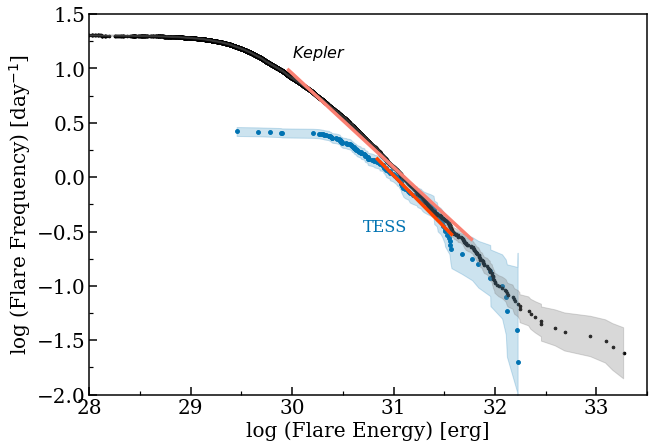

In [170]:
fig,ax = plt.subplots(figsize=(10,7))
#font = {'size'   : 20}
#plt.rc('font', **font)

plt.scatter(tess_x,tess_y, color='C0',s=15) #, label='TESS'
plt.scatter(kep_x,kep_y, color='k',s=7)
plt.xlabel('log (Flare Energy) [erg]')
plt.ylabel(r'log (Flare Frequency) [day$^{-1}$]')
#plt.title('GJ 1243')
#plt.legend() 

# Add labels to the plot
style = dict(size=16)
ax.text(30.7, -0.5, "TESS", **style,color='C0')
ax.text(30, 1.1, "$\it{Kepler}$", **style)

#axes
#plt.rcParams['axes.linewidth']=1.5

plt.tick_params(axis='both',direction="in")
from matplotlib.ticker import (AutoMinorLocator,MultipleLocator)
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(which='minor', direction='in',width=1.2,length=4)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
plt.tick_params(axis='both',direction="in",width=1.5,length=8)
ax.set_xlim(28,33.5)
ax.set_ylim(-2,1.5)

#fitting a line

from scipy import polyfit
kep_polyfit, cov = np.polyfit(kep_x[no_nan_mask][60:2500], kep_y[no_nan_mask][60:2500],1,full=False, cov=True)

plt.plot(kep_x[no_nan_mask][60:2500],np.polyval(kep_polyfit, kep_x[no_nan_mask][60:2500]),color='salmon',linewidth=3.5)
kep_polyfit,np.sqrt(np.diag(cov)) #uncertainities on m and b

print('Kepler',kep_polyfit,np.sqrt(np.diag(cov)))


#Combining both fits onto one plot
tess_polyfit,cov= np.polyfit(tess_x[10:70],tess_y[10:70],1,full=False, cov=True)

plt.plot(tess_x[10:70],np.polyval(tess_polyfit,tess_x[10:70]),color='orangered',linewidth=3.5)
print('TESS',tess_polyfit,np.sqrt(np.diag(cov))) #uncertainities on m and b


#Error bars
plt.fill_between(tess_x, tess_y - tess_log_yerr, tess_y + tess_log_yerr,color='C0', alpha=0.2)
plt.fill_between(kep_x[no_nan_mask], kep_y[no_nan_mask] - kep_log_yerr[no_nan_mask], kep_y[no_nan_mask] + 
                 kep_log_yerr[no_nan_mask],color='grey', alpha=0.3)
#plt.errorbar(tess_x,tess_y,xerr= tess_ffd_xerr,yerr= tess_log_yerr,ecolor='orangered',alpha=0.3,elinewidth=1)
#plt.errorbar(kep_x[no_nan_mask],kep_y[no_nan_mask],xerr=kep_ffd_xerr[no_nan_mask],yerr=kep_log_yerr[no_nan_mask],
             #ecolor='salmon',alpha=0.3)

#plt.savefig('ffd_fit.pdf',dpi=300, bbox_inches='tight', pad_inches=0.5)

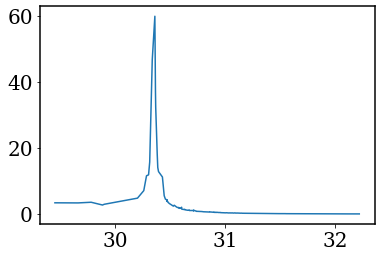

In [155]:
plt.plot(tess_x,tess_ffd_xerr)

(-2, 1)

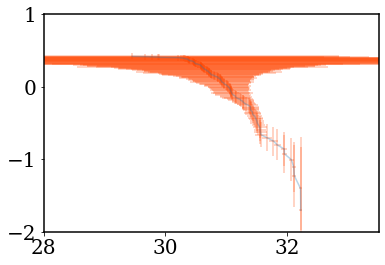

In [156]:
plt.errorbar(tess_x,tess_y,xerr=tess_ffd_xerr,yerr=tess_log_yerr,ecolor='orangered',alpha=0.3)
plt.xlim(28,33.5)
plt.ylim(-2,1)

(-2, 1.5)

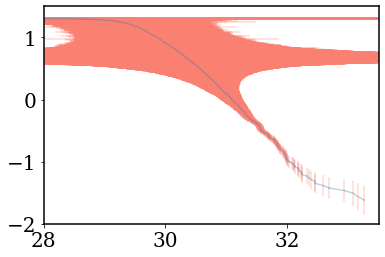

In [157]:
plt.errorbar(kep_x,kep_y,xerr=kep_ffd_xerr,yerr=kep_log_yerr,ecolor='salmon',alpha=0.3)
plt.xlim(28,33.5)
plt.ylim(-2,1.5)

In [158]:
import seaborn
seaborn.set_palette('colorblind')

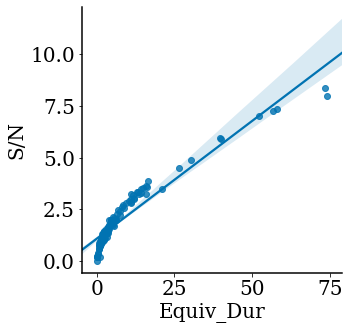

In [159]:
seaborn.lmplot(x="Equiv_Dur", y="S/N", data=all_tess_flares, y_jitter=tess_log_yerr);